In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.set_figure_params(dpi_save=600)
adata=sc.read("data/adata_aligned.h5ad")

In [2]:
import scFates as scf

In [3]:
scf.set_figure_pubready()

In [4]:
DVD=pd.read_table("DVD.r8.2.1.2019-12-05.download.tsv")
df_genes=DVD.loc[DVD.FINAL_PATHOGENICITY.isin(['Pathogenic','Likely%20pathogenic']),"GENE"].unique()
DVD_sub=DVD.loc[DVD.FINAL_PATHOGENICITY.isin(['Pathogenic','Likely%20pathogenic']),:]
df_genes=np.char.capitalize(np.array(list(map(lambda x: x.split("%20")[0],df_genes))))

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


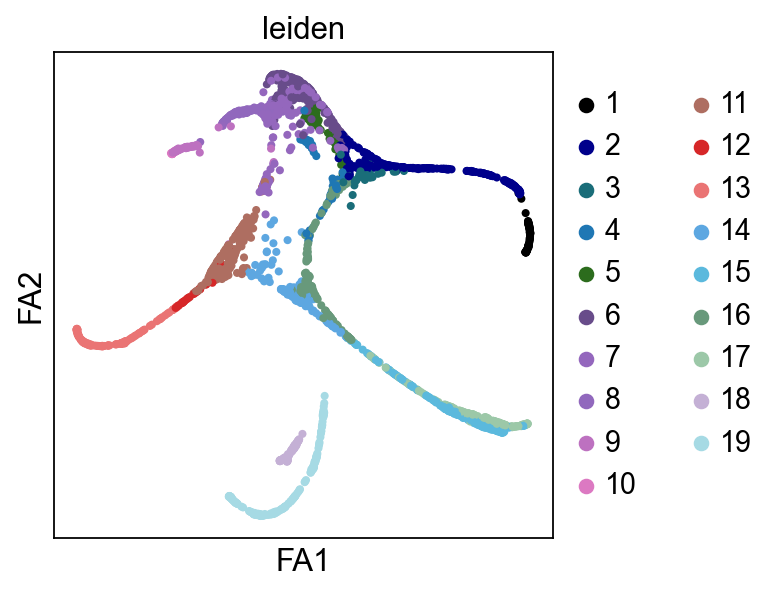

In [5]:
sc.pl.draw_graph(adata,color="leiden")

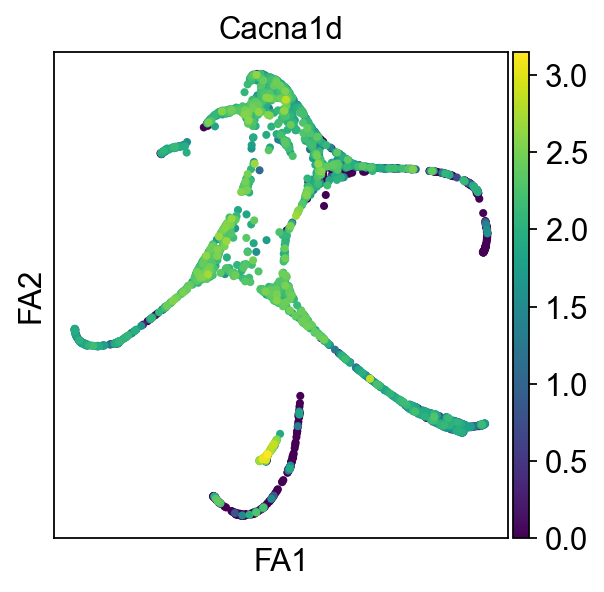

In [6]:
sc.pl.draw_graph(adata,color="Cacna1d")

In [7]:
adata=sc.read("data/adata_aligned.h5ad")
adata_HC=sc.read("data/adata_HC.h5ad")

In [8]:
adata.obs["annot"]=adata.obs.leiden.astype(str)
adata_HC.obs.leiden=adata_HC.obs.leiden.replace(["0","1"],["IHC","OHC"])

In [9]:
adata.obs.loc[adata_HC[adata_HC.obs.leiden=="IHC"].obs_names,"annot"]="IHC"
adata.obs.loc[adata_HC[adata_HC.obs.leiden=="OHC"].obs_names,"annot"]="OHC"

In [10]:
adata=adata[adata.obs.leiden!="19"]
adata=adata[adata.obs.annot!="18"]

In [11]:
adata_tree=sc.read("data/adata_tree.h5ad")

In [12]:
adata.obs.loc[adata_tree.obs_names,"annot"]=adata_tree.obs.seg.astype(str)

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'annot' as categorical


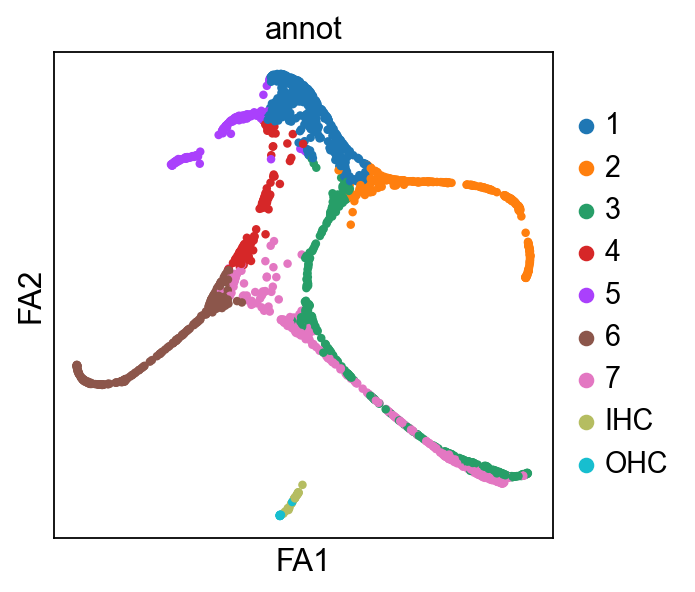

In [13]:
sc.pl.draw_graph(adata,color="annot")

In [14]:
import igraph
graph = adata_tree.uns["graph"]

dct = graph["milestones"]
keys = np.array(list(dct.keys()))
vals = np.array(list(dct.values()))

edges = graph["pp_seg"][["from", "to"]].astype(str).apply(tuple, axis=1).values
img = igraph.Graph(directed=True)
img.add_vertices(vals.astype(str))
img.add_edges(edges)

allpaths=img.get_all_shortest_paths(str(graph["root"]),to=graph["tips"].astype(str))

allpaths=np.array(allpaths)[np.argsort(np.array([len(p) for p in allpaths]))]

order=allpaths[0]
for i in range(1,len(allpaths)):
    order=order+np.array(allpaths[i])[~np.isin(allpaths[i],order)].tolist()

<ipython-input-14-1ba3864a52a4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  allpaths=np.array(allpaths)[np.argsort(np.array([len(p) for p in allpaths]))]


In [15]:
order=np.array(order)[1:]

order=pd.Series(graph["milestones"].keys(),index=graph["milestones"].values())[np.array(img.vs["name"])[order].astype(int)]
order=pd.Series(range(len(adata_tree.obs.seg.cat.categories)),index=graph["pp_seg"]["to"])[order.index].values

In [16]:
cellsel=[pd.cut(adata_tree.obs.t[adata_tree.obs.seg==s],2) for s in adata_tree.obs.seg.cat.categories[order]]

In [17]:
cellsel[0].cat.categories

IntervalIndex([(0.0074, 9.991], (9.991, 19.954]], dtype='interval[float64, right]')

In [18]:
adata.obs.annot=adata.obs.annot.astype(str)

In [19]:
neworder=list()
for i,s in enumerate(adata_tree.obs.seg.cat.categories[order]):
    e,l = cellsel[i].cat.categories
    adata.obs.loc[cellsel[i][cellsel[i]==e].index,"annot"]=s+"_early"
    neworder.append(s+"_early")
    adata.obs.loc[cellsel[i][cellsel[i]==l].index,"annot"]=s+"_late"
    neworder.append(s+"_late")

... storing 'annot' as categorical


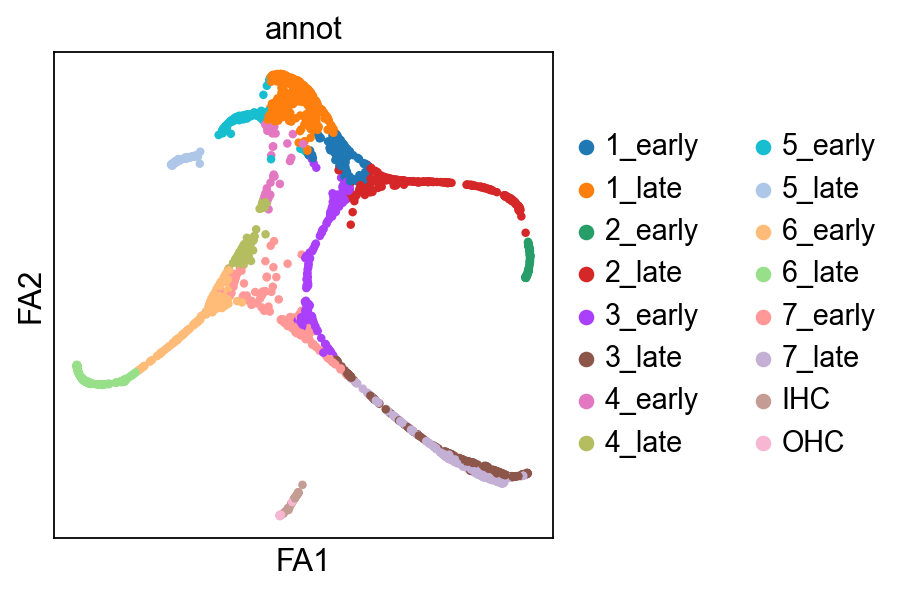

In [20]:
sc.pl.draw_graph(adata,color="annot")

In [21]:
adata_SGN=adata[adata.obs.annot.isin(adata.obs.annot.cat.categories[:-2])]
df_genes=adata.var_names[adata.var_names.isin(df_genes)]

In [22]:
df_SGN=pd.DataFrame(np.vstack(list(map(lambda a: adata_SGN[adata_SGN.obs.annot==a,df_genes].X.A.mean(axis=0),adata_SGN.obs.annot.cat.categories))),
             index=adata_SGN.obs.annot.cat.categories,columns=df_genes)

In [23]:
df_genes_SGN=df_SGN.columns[df_SGN.apply(lambda x: any(x>1))]

In [24]:
df_genes_SGN.sort_values(ascending=False)

Index(['Wfs1', 'Triobp', 'Tnc', 'Tmprss3', 'Tmem132e', 'Tjp2', 'Tcof1',
       'Tbc1d24', 'Syne4', 'Six1', 'Ptprq', 'Prps1', 'Polr1d', 'Polr1c',
       'Pnpt1', 'Pex6', 'Pex1', 'Pdzd7', 'Osbpl2', 'Opa1', 'Nars2', 'Myo6',
       'Myh9', 'Myh14', 'Lhfpl5', 'Lars2', 'Kars', 'Homer2', 'Hars2', 'Grxcr1',
       'Gata3', 'Fam65b', 'Eya4', 'Eya1', 'Espn', 'Elmod3', 'Diablo', 'Dfna5',
       'Crym', 'Coch', 'Clrn1', 'Clpp', 'Cisd2', 'Cib2', 'Ccdc50', 'Cacna1d',
       'Bdp1', 'Atp2b2', 'Aifm1', 'Adcy1', 'Actg1'],
      dtype='object', name='gene')

In [25]:
adata_HC=adata[adata.obs.annot.isin(adata.obs.annot.cat.categories[-2:])]
df_HC=pd.DataFrame(np.vstack(list(map(lambda a: adata_HC[adata_HC.obs.annot==a,df_genes].X.A.mean(axis=0),adata_HC.obs.annot.cat.categories))),
             index=adata_HC.obs.annot.cat.categories,columns=df_genes)
df_genes_HC=df_HC.columns[df_HC.apply(lambda x: any(x>1))]
df_genes_HC.sort_values(ascending=False)

Index(['Wfs1', 'Ush2a', 'Ush1g', 'Ush1c', 'Triobp', 'Tprn', 'Tnc', 'Tmprss3',
       'Tmie', 'Tmc1', 'Tjp2', 'Tecta', 'Tcof1', 'Tbc1d24', 'Syne4', 'Strc',
       'Smpx', 'Slitrk6', 'Slc26a5', 'Slc22a4', 'Slc17a8', 'Six1', 'Ptprq',
       'Prps1', 'Pou4f3', 'Polr1d', 'Polr1c', 'Pnpt1', 'Pex6', 'Pex1', 'Pdzd7',
       'Pcdh15', 'P2rx2', 'Otogl', 'Otog', 'Otof', 'Otoa', 'Osbpl2', 'Opa1',
       'Nars2', 'Myo7a', 'Myo6', 'Myo3a', 'Myh9', 'Myh14', 'Msrb3', 'Marveld2',
       'Loxhd1', 'Lhfpl5', 'Lars2', 'Kcnq4', 'Kars', 'Ildr1', 'Homer2',
       'Hars2', 'Grxcr2', 'Grxcr1', 'Gjb6', 'Gjb2', 'Gata3', 'Fgf3', 'Fam65b',
       'Eya4', 'Eya1', 'Espn', 'Eps8', 'Elmod3', 'Diablo', 'Dfnb59', 'Crym',
       'Col9a1', 'Col11a2', 'Clrn1', 'Clpp', 'Clic5', 'Cldn14', 'Cisd2',
       'Cib2', 'Cdh23', 'Cdc14a', 'Ccdc50', 'Cacna1d', 'Cabp2', 'Bdp1',
       'Atp2b2', 'Alms1', 'Aifm1', 'Adcy1', 'Actg1'],
      dtype='object', name='gene')

In [26]:
from scFates.tools.utils import get_X

In [27]:
cl=[]
for c in adata_HC.obs.annot.cat.categories:
    means=[]
    for l in get_X(adata_HC,
                   adata_HC.obs_names[adata_HC.obs.annot==c],
                   df_genes_HC,
                   layer=None,
                   togenelist=True):
        means.append(np.mean(l))
    cl.append(pd.Series(means,index=df_genes_HC,name=c))

clu_means=pd.concat(cl,axis=1)

In [28]:
clu_means.to_csv("Deafness_HC.csv")

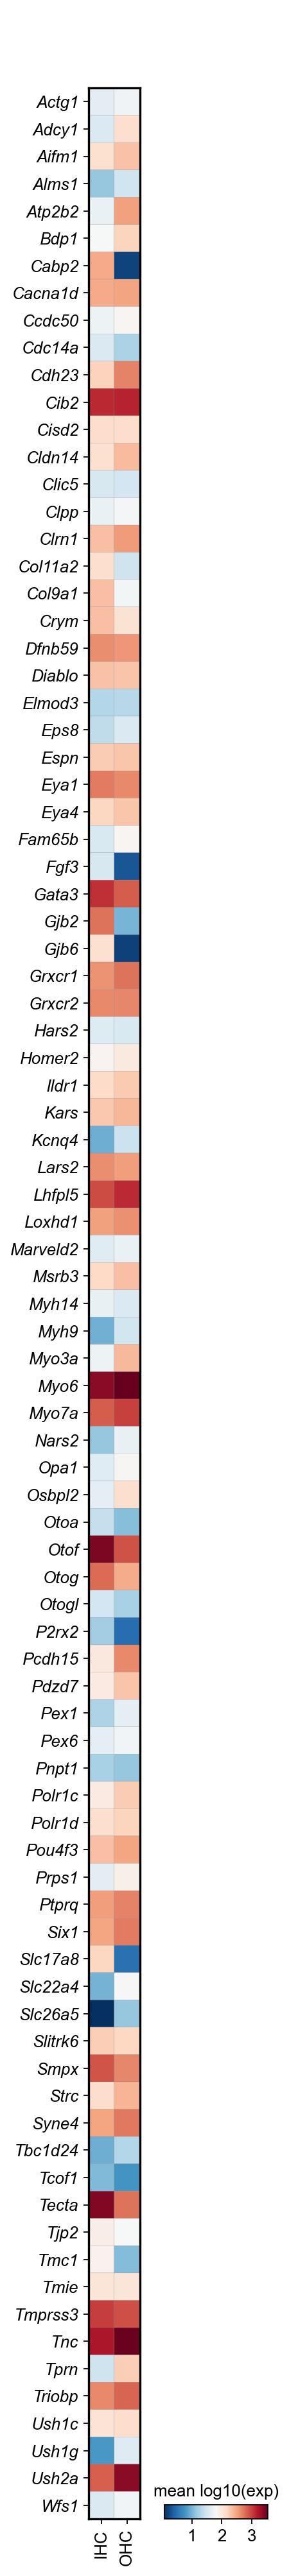

In [29]:
ax=sc.pl.matrixplot(adata_HC,df_genes_HC.sort_values(), 'annot', dendrogram=False,
                 colorbar_title='mean log10(exp)',swap_axes=True,
                 show=False,cmap="RdBu_r")
plt.setp(ax['mainplot_ax'].get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor",style="italic");
plt.savefig("figures/deafness_HC.pdf")

Trying to set attribute `.obs` of view, copying.


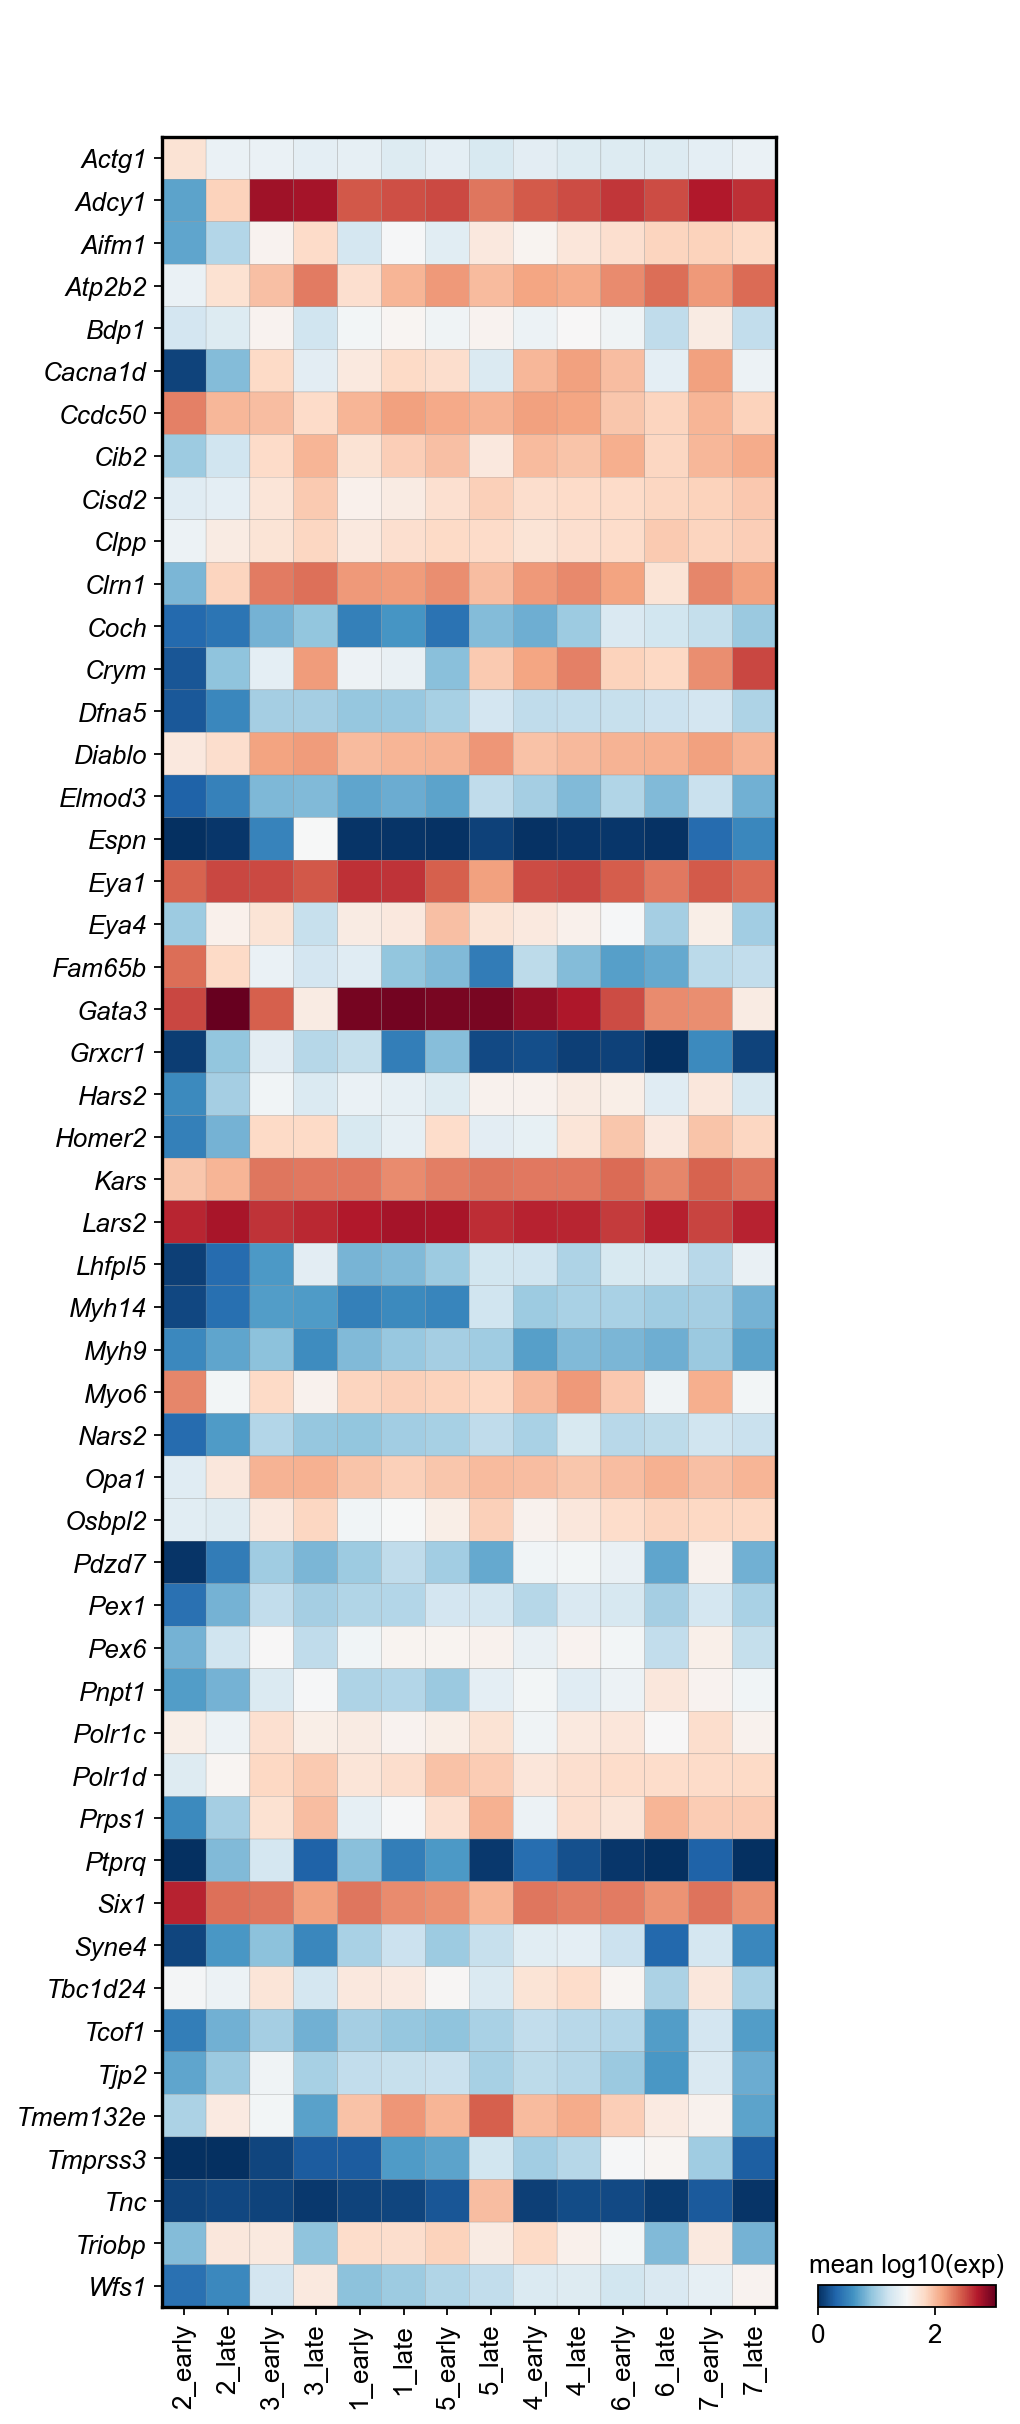

In [30]:
adata_SGN.obs.annot=adata_SGN.obs.annot.cat.reorder_categories(neworder)
ax=sc.pl.matrixplot(adata_SGN,df_genes_SGN.sort_values(), 'annot', dendrogram=False,
                 colorbar_title='mean log10(exp)',swap_axes=True,
                 show=False,cmap="RdBu_r")
plt.setp(ax['mainplot_ax'].get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor",style="italic");
plt.savefig("figures/deafness_SGN.pdf")

In [31]:
cl=[]
for c in adata_SGN.obs.annot.cat.categories:
    means=[]
    for l in get_X(adata_SGN,
                   adata_SGN.obs_names[adata_SGN.obs.annot==c],
                   df_genes_SGN,
                   layer=None,
                   togenelist=True):
        means.append(np.mean(l))
    cl.append(pd.Series(means,index=df_genes_SGN,name=c))

clu_means=pd.concat(cl,axis=1)

In [32]:
clu_means

,2_early,2_late,3_early,3_late,1_early,1_late,5_early,5_late,4_early,4_late,6_early,6_late,7_early,7_late
gene,,,,,,,,,,,,,,
Eya1,2.417951,2.537020,2.528201,2.472080,2.631561,2.618213,2.432169,2.146039,2.513933,2.535050,2.440724,2.331520,2.452868,2.379660
Gata3,2.536001,3.045757,2.434339,1.644463,2.984587,2.993682,2.964693,2.967114,2.863132,2.751186,2.521269,2.239624,2.233677,1.647009
Osbpl2,1.348486,1.324176,1.678973,1.846285,1.469474,1.517368,1.620403,1.891633,1.588835,1.691919,1.807117,1.857830,1.837946,1.842896
Clrn1,0.830407,1.865746,2.310276,2.363081,2.181438,2.172585,2.230747,1.997948,2.182353,2.260494,2.139309,1.734043,2.268309,2.148702
Cisd2,1.337846,1.375108,1.724453,1.923521,1.601517,1.642983,1.764146,1.890450,1.791586,1.812851,1.810838,1.852736,1.874617,1.929035
Tnc,0.113198,0.134314,0.118856,0.048416,0.110863,0.120884,0.223544,1.987643,0.093777,0.155177,0.151386,0.063022,0.241198,0.032799
Espn,0.000000,0.040652,0.510389,1.521225,0.027700,0.025237,0.016927,0.105068,0.020490,0.039257,0.040220,0.015660,0.354969,0.529189
Grxcr1,0.083051,0.924025,1.357919,1.092114,1.163039,0.465091,0.871473,0.154597,0.171900,0.085046,0.095999,0.007038,0.557888,0.114686
Pex1,0.391196,0.805136,1.151632,1.011170,1.060655,1.079343,1.238362,1.260765,1.085486,1.292653,1.264228,1.010234,1.249979,1.032737


In [33]:
clu_means.to_csv("Deafness_SGN.csv")

In [34]:
adata_tree=sc.read("data/adata_tree_fitted.h5ad")

In [35]:
import scFates as scf

In [36]:
adata_tree=adata_tree.raw.to_adata()

In [37]:
adata_tree

AnnData object with n_obs × n_vars = 2005 × 20699
    obs: 'batch', 'plate', 'devtime', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'leiden', 't', 'seg', 'edge', 'milestones', 'devtime_float'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable', 'p_val', 'A', 'fdr', 'st', 'signi'
    uns: 'dendro_segments', 'devtime_colors', 'doublets_colors', 'draw_graph', 'graph', 'leiden', 'leiden_colors', 'log1p', 'milestones_colors', 'neighbors', 'ppt', 'pseudotime_list', 'seg_colors', 'stat_assoc_list', 'tsne', 'umap'
    obsm: 'X_R', 'X_dendro', 'X_draw_graph_fa', 'X_msdiff', 'X_pca', 'X_tsne', 'X_umap'

In [38]:
scf.tl.fit(adata_tree,df_genes_SGN.n_jobs=51)

fit features associated with the trajectory
    single mapping : 100%|██████████| 51/51 [00:32<00:00,  1.58it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:32) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


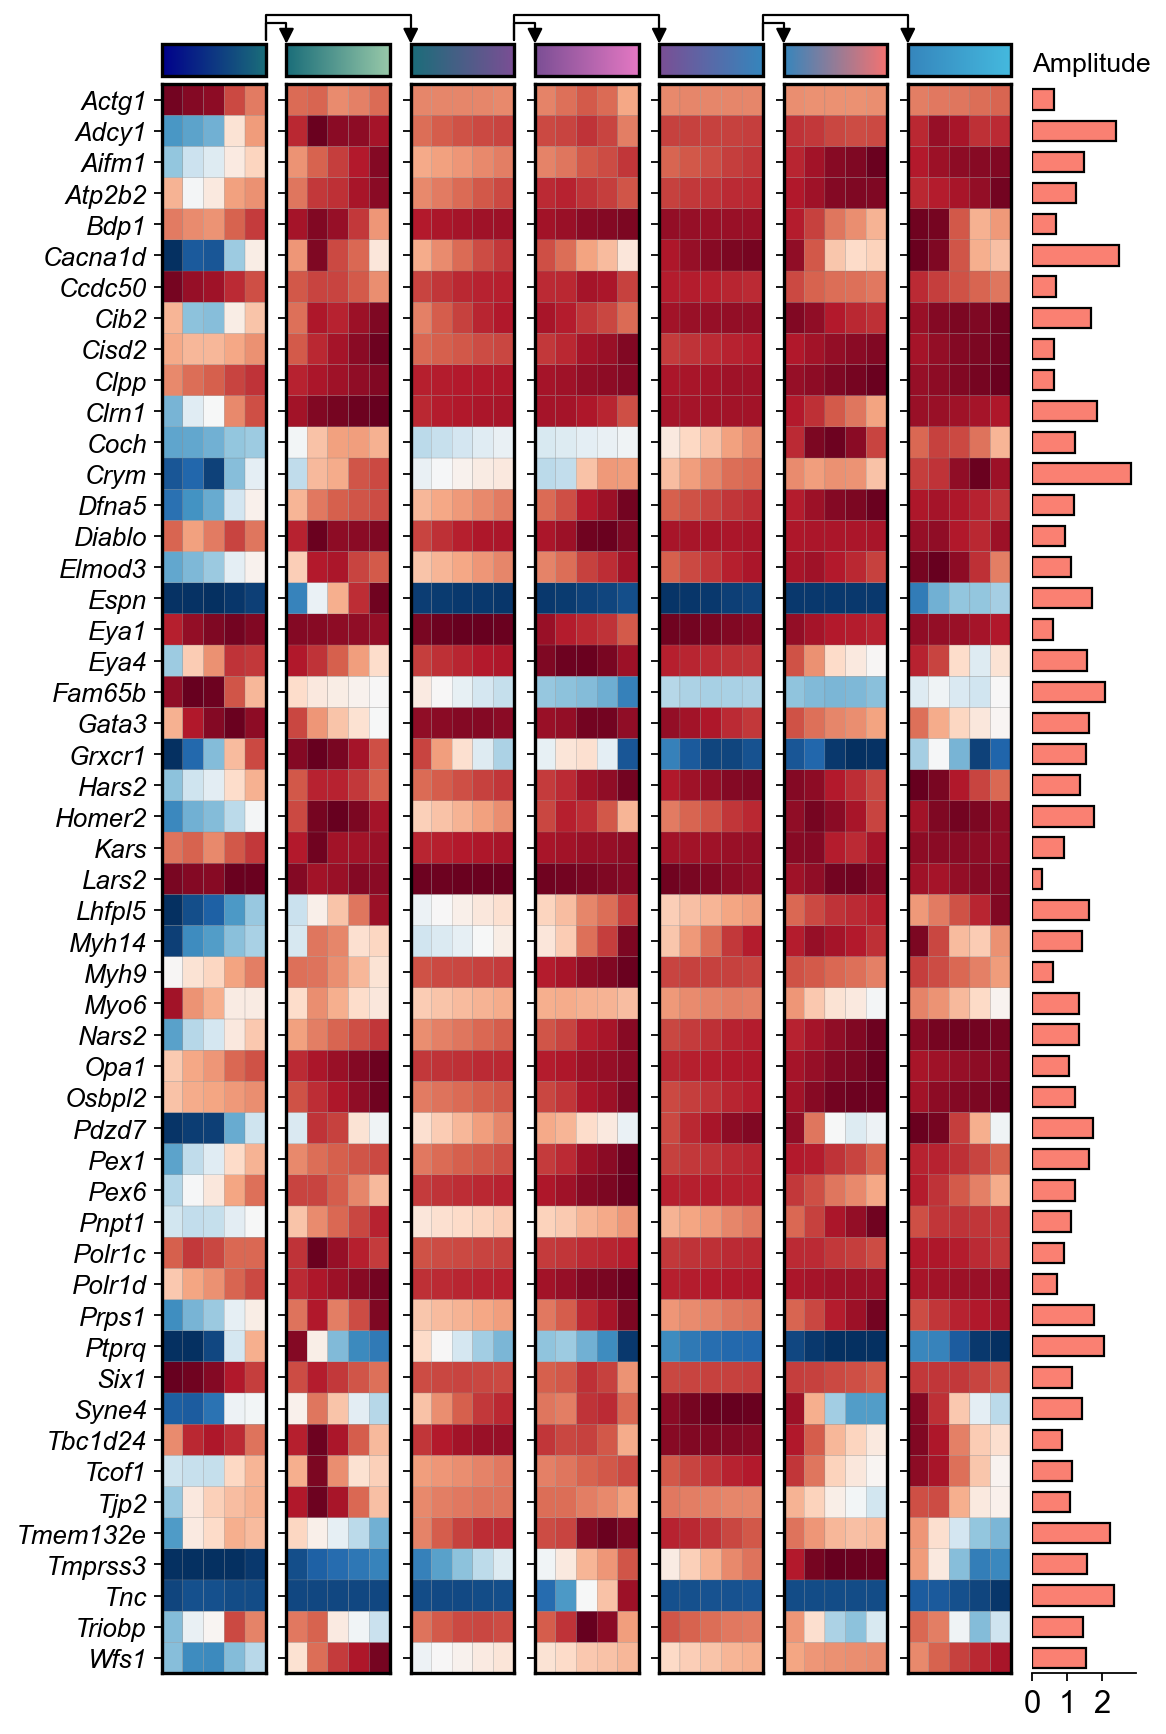

In [39]:
scf.pl.matrix(adata_tree,df_genes_SGN.sort_values(ascending=False),nbins=5,
              feature_style="italic",annot_var=True,cmap="RdBu_r",
              save="_SGN_Deafness.pdf")

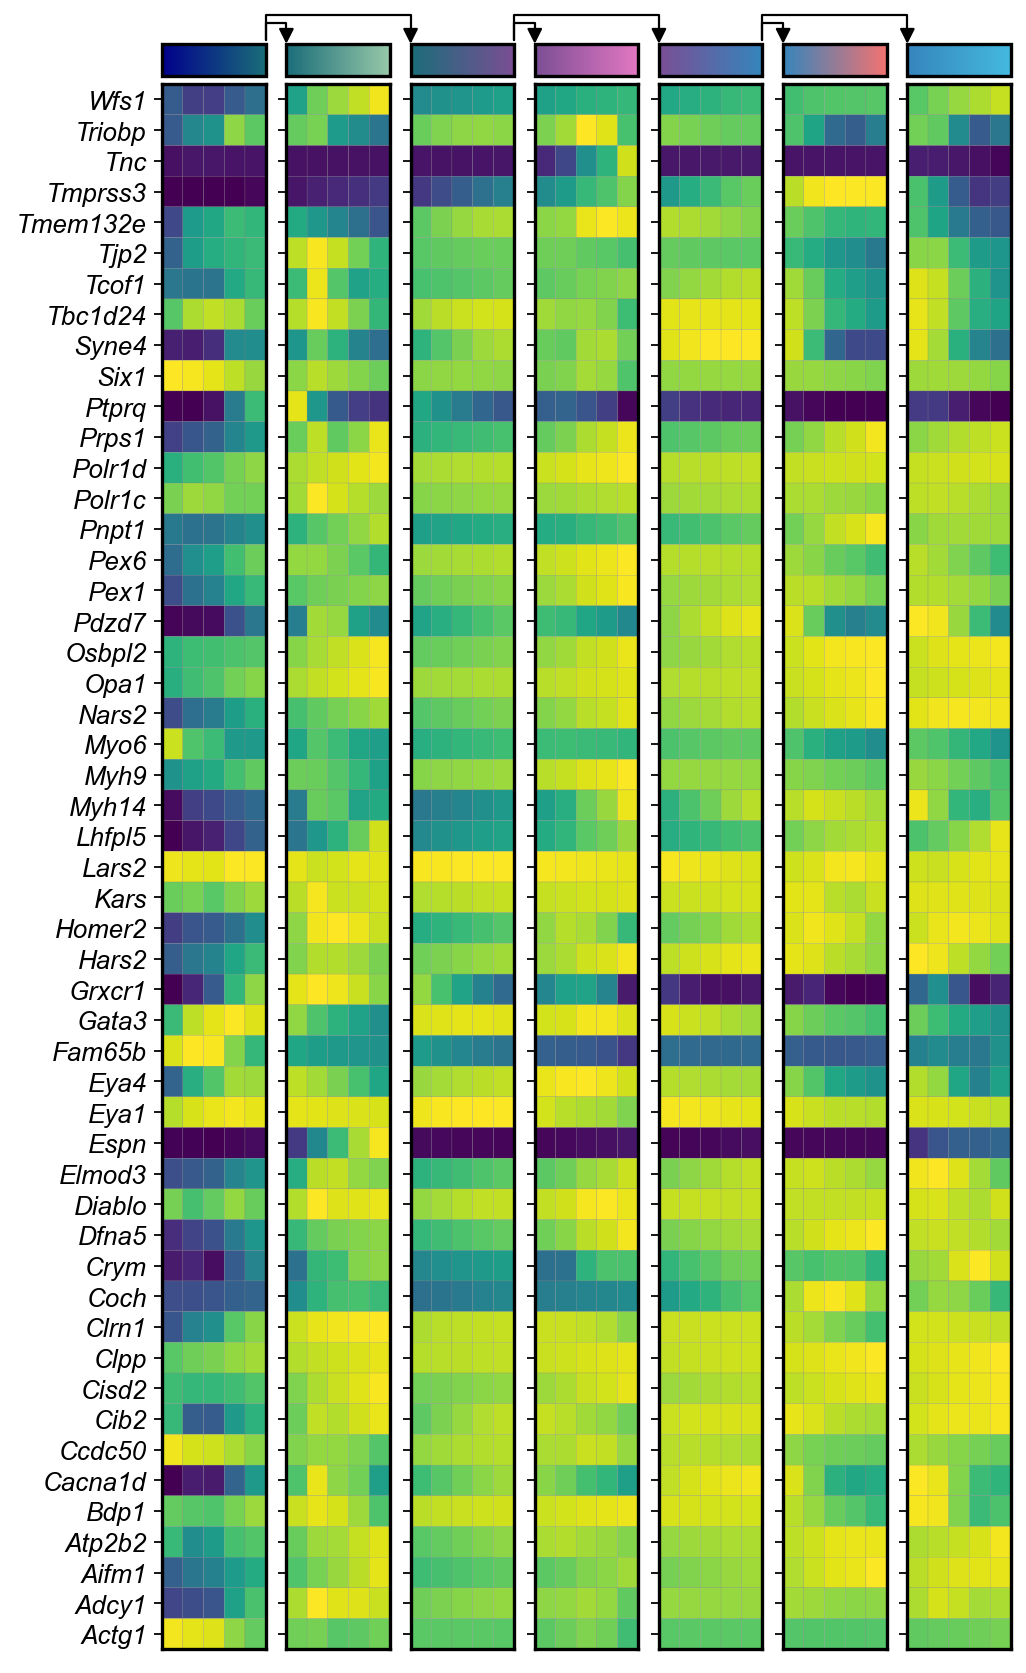

In [40]:
data=scf.pl.matrix(adata_tree,df_genes_SGN.sort_values(ascending=False),nbins=5,
              feature_style="italic",return_data=True)

In [42]:
writer = pd.ExcelWriter('data/Deafness_trajectory.xlsx', engine='xlsxwriter')
for k,v in data.items():
    v.to_excel(writer, sheet_name=k)
    
writer.save()

{'immature->A':           (0.0074, 4.013]  (4.013, 7.998]  (7.998, 11.983]  (11.983, 15.968]  \
 gene                                                                           
 Wfs1             0.286527        0.184876         0.183510          0.281488   
 Triobp           0.282765        0.462409         0.509674          0.831819   
 Tnc              0.042091        0.061349         0.059969          0.052966   
 Tmprss3         -0.004252       -0.003204        -0.007361          0.000114   
 Tmem132e         0.216404        0.545842         0.596877          0.680691   
 Tjp2             0.311744        0.553968         0.617233          0.653437   
 Tcof1            0.394635        0.384502         0.378927          0.601871   
 Tbc1d24          0.734916        0.877967         0.905806          0.871915   
 Syne4            0.088421        0.082664         0.130254          0.475613   
 Six1             0.999754        0.985838         0.957636          0.901532   
 Ptprq       

In [14]:
df_genes=adata.var_names[adata.var_names.isin(df_genes)]
df=pd.DataFrame(np.vstack(list(map(lambda a: adata[adata.obs.annot==a,df_genes].X.A.mean(axis=0),adata.obs.annot.cat.categories))),
             index=adata.obs.annot.cat.categories,columns=df_genes)

In [15]:
df_genes=df.columns[df.apply(lambda x: any(x>1))]

In [17]:
df_genes.sort_values()

Index(['Actg1', 'Adcy1', 'Aifm1', 'Alms1', 'Atp2b2', 'Bdp1', 'Cabp2',
       'Cacna1d', 'Ccdc50', 'Cdc14a', 'Cdh23', 'Cib2', 'Cisd2', 'Cldn14',
       'Clic5', 'Clpp', 'Clrn1', 'Coch', 'Col11a2', 'Col9a1', 'Crym', 'Dfna5',
       'Dfnb59', 'Diablo', 'Elmod3', 'Eps8', 'Espn', 'Eya1', 'Eya4', 'Fam65b',
       'Fgf3', 'Gata3', 'Gjb2', 'Gjb6', 'Grxcr1', 'Grxcr2', 'Hars2', 'Homer2',
       'Ildr1', 'Kars', 'Kcnq4', 'Lars2', 'Lhfpl5', 'Loxhd1', 'Marveld2',
       'Msrb3', 'Myh14', 'Myh9', 'Myo3a', 'Myo6', 'Myo7a', 'Nars2', 'Opa1',
       'Osbpl2', 'Otoa', 'Otof', 'Otog', 'Otogl', 'P2rx2', 'Pcdh15', 'Pdzd7',
       'Pex1', 'Pex6', 'Pnpt1', 'Polr1c', 'Polr1d', 'Pou4f3', 'Prps1', 'Ptprq',
       'Six1', 'Slc17a8', 'Slc22a4', 'Slc26a5', 'Slitrk6', 'Smpx', 'Strc',
       'Syne4', 'Tbc1d24', 'Tcof1', 'Tecta', 'Tjp2', 'Tmc1', 'Tmem132e',
       'Tmie', 'Tmprss3', 'Tnc', 'Tprn', 'Triobp', 'Ush1c', 'Ush1g', 'Ush2a',
       'Wfs1'],
      dtype='object', name='gene')

In [22]:
adata_SGN

View of AnnData object with n_obs × n_vars = 2005 × 20699
    obs: 'batch', 'plate', 'devtime', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'leiden', 'annot'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'devtime_colors', 'doublets_colors', 'draw_graph', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'tsne', 'umap', 'annot_colors'
    obsm: 'X_draw_graph_fa', 'X_msdiff', 'X_pca', 'X_tsne', 'X_umap'
    layers: 'palantir_imp', 'scaled'
    obsp: 'T', 'connectivities', 'distances'

In [33]:
SGN=[]
for g in df_genes:
    SGN.append(np.any([adata[adata.obs.annot==a,g].layers["scaled"].mean(axis=0)>1 for a in adata.obs.annot.cat.categories[:-2]]))

Trying to set attribute `.obs` of view, copying.


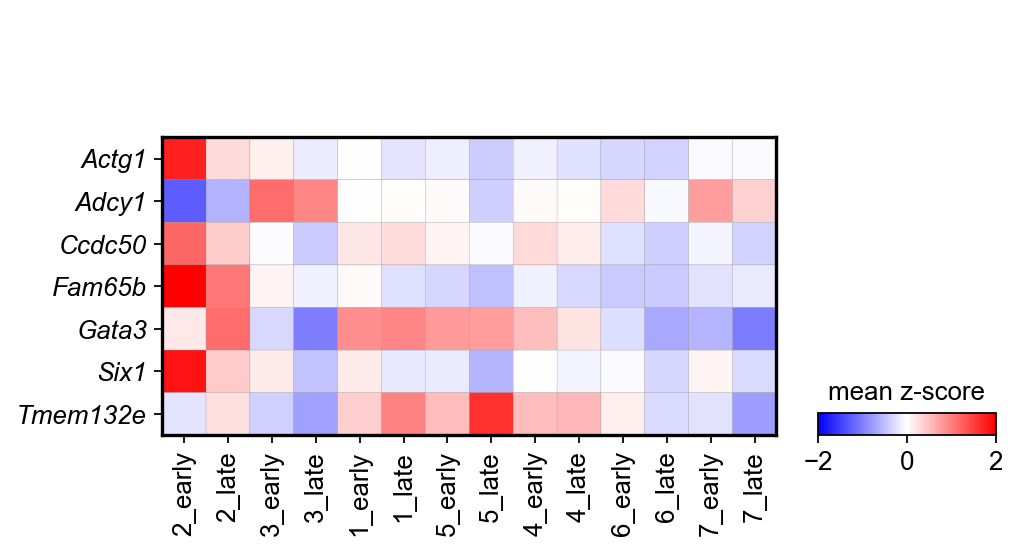

In [64]:
adata_SGN=adata[adata.obs.annot.isin(adata.obs.annot.cat.categories[:-2])]
adata_SGN.obs.annot=adata_SGN.obs.annot.cat.reorder_categories(neworder)
ax=sc.pl.matrixplot(adata_SGN,df_genes[SGN].sort_values(), 'annot', dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', cmap='bwr',vmin=-2, vmax=2,swap_axes=True,
                 show=False)

plt.setp(ax['mainplot_ax'].get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor",style="italic");
plt.savefig("figures/deafness_SGN.pdf")

In [60]:
HC=[]
for g in df_genes:
    HC.append(np.any([adata[adata.obs.annot==a,g].layers["scaled"].mean(axis=0)>1 for a in adata.obs.annot.cat.categories[-2:]]))

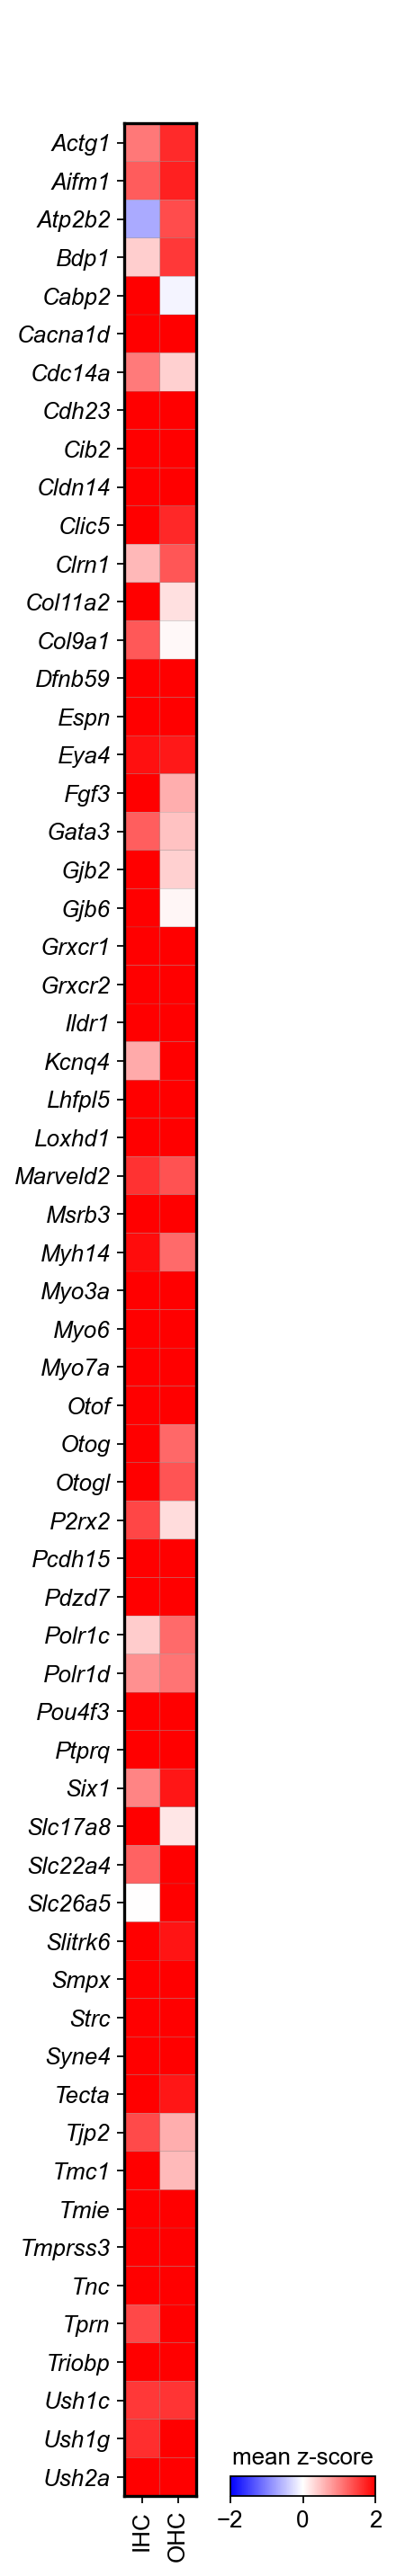

In [63]:
adata_HC=adata[adata.obs.annot.isin(adata.obs.annot.cat.categories[-2:])]

ax=sc.pl.matrixplot(adata_HC,df_genes[HC].sort_values(), 'annot', dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', cmap='bwr',vmin=-2, vmax=2,swap_axes=True,
                 show=False)
plt.setp(ax['mainplot_ax'].get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor",style="italic");
plt.savefig("figures/deafness_HC.pdf")

In [22]:
non_HC=df_genes[adata[~adata.obs.annot.isin(["IHC","OHC"]),df_genes].layers["scaled"].mean(axis=0)>1]
HC=df_genes[adata[adata.obs.leiden=="18",df_genes].layers["scaled"].mean(axis=0)>1.5]
non_Otic=df_genes[adata[adata.obs.leiden=="19",df_genes].layers["scaled"].mean(axis=0)<1.5]
Otic=df_genes[adata[adata.obs.leiden=="19",df_genes].layers["scaled"].mean(axis=0)>1.5]

AnnData object with n_obs × n_vars = 2044 × 20699
    obs: 'batch', 'plate', 'devtime', 'n_genes_by_counts', 'total_counts', 'total_counts_ERCC', 'pct_counts_ERCC', 'leiden', 'annot'
    var: 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'devtime_colors', 'doublets_colors', 'draw_graph', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'rank_genes_groups', 'tsne', 'umap', 'annot_colors'
    obsm: 'X_draw_graph_fa', 'X_msdiff', 'X_pca', 'X_tsne', 'X_umap'
    layers: 'palantir_imp', 'scaled'
    obsp: 'T', 'connectivities', 'distances'

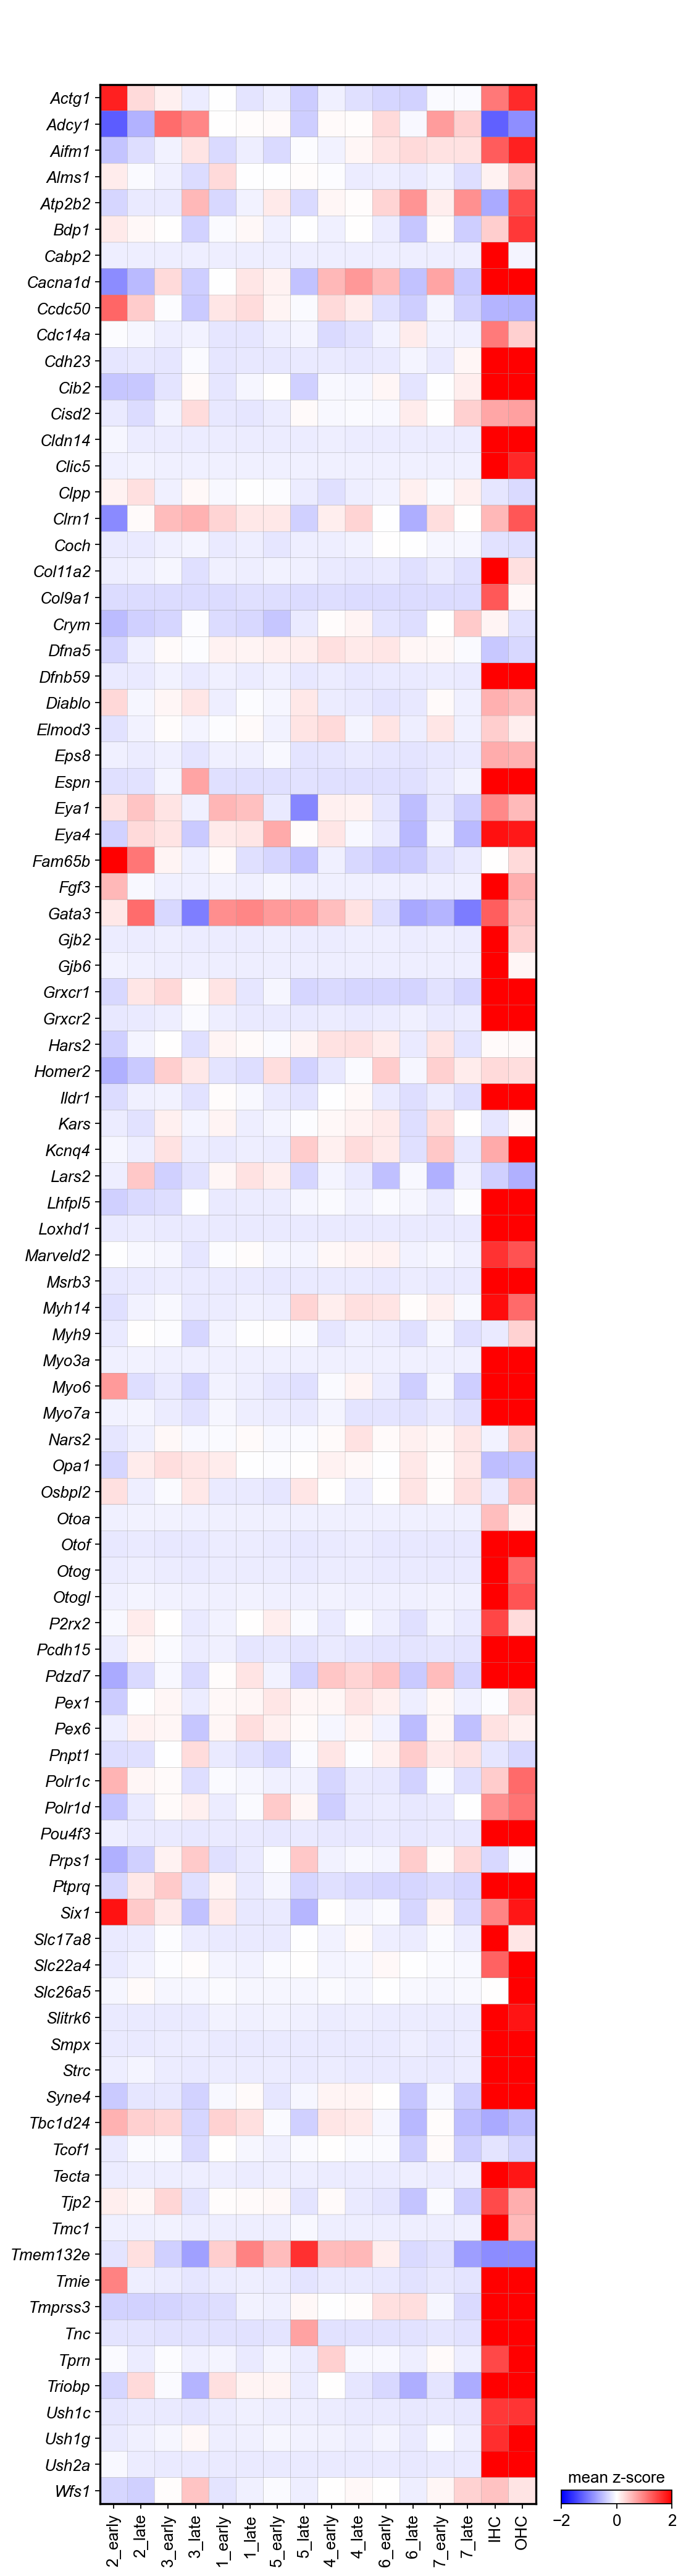

In [22]:
adata.obs.annot=adata.obs.annot.cat.reorder_categories(neworder+['IHC', 'OHC'])
ax=sc.pl.matrixplot(adata,df_genes.sort_values(), 'annot', dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', cmap='bwr',vmin=-2, vmax=2,swap_axes=True,
                 show=False)
plt.setp(ax['mainplot_ax'].get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor",style="italic");
plt.savefig("figures/deafness_all.pdf")

In [23]:
sc.tl.rank_genes_groups(adata,'leiden',method="wilcoxon")

In [28]:
hc_genes=sc.get.rank_genes_groups_df(adata,"18",log2fc_min=0,pval_cutoff=0.05).set_index("names").index

In [33]:
hc=df_genes[df_genes.isin(hc_genes)].sort_values()

sgn=df_genes[~df_genes.isin(hc_genes)].sort_values()

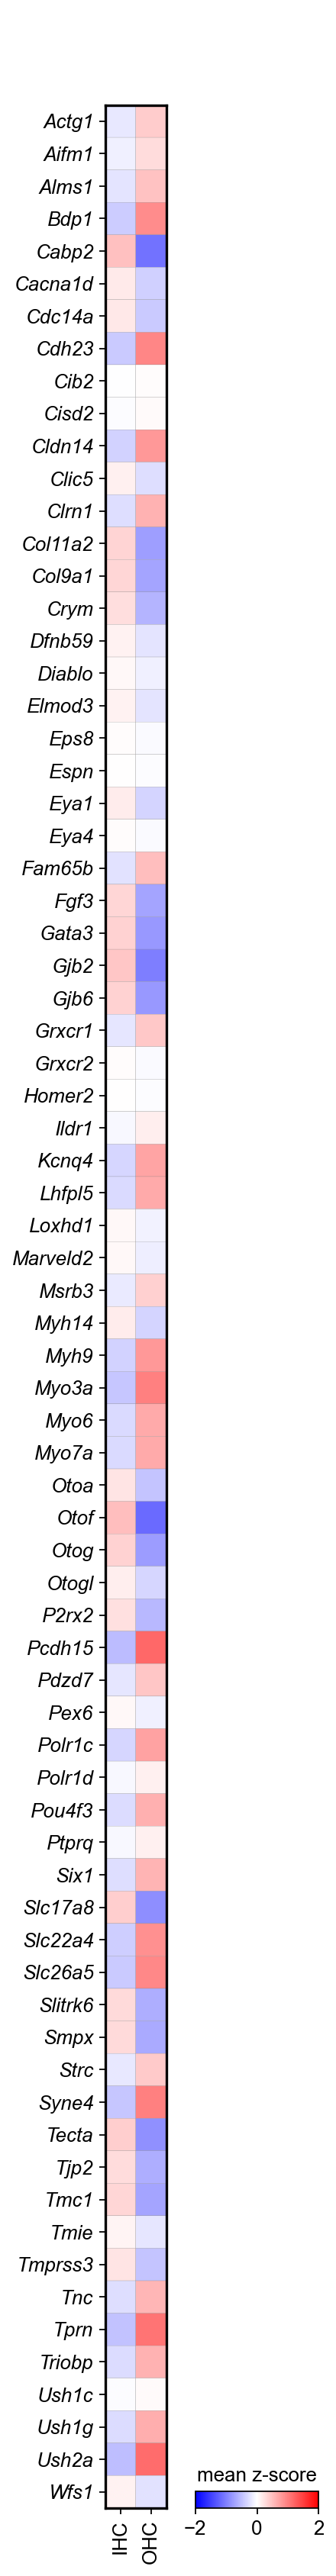

In [36]:
adata.obs.annot=adata.obs.annot.cat.reorder_categories(neworder+['IHC', 'OHC'])
ax=sc.pl.matrixplot(adata_HC,hc, 'leiden', dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', cmap='bwr',vmin=-2, vmax=2,swap_axes=True,
                 show=False)
plt.setp(ax['mainplot_ax'].get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor",style="italic");
plt.savefig("figures/deafness_HC.pdf")

In [37]:
adata_SGN=adata[~adata.obs.leiden.isin(["18","19"])]

In [38]:
adata_SGN.layers["scaled"]=sc.pp.scale(adata_SGN.X,copy=True)

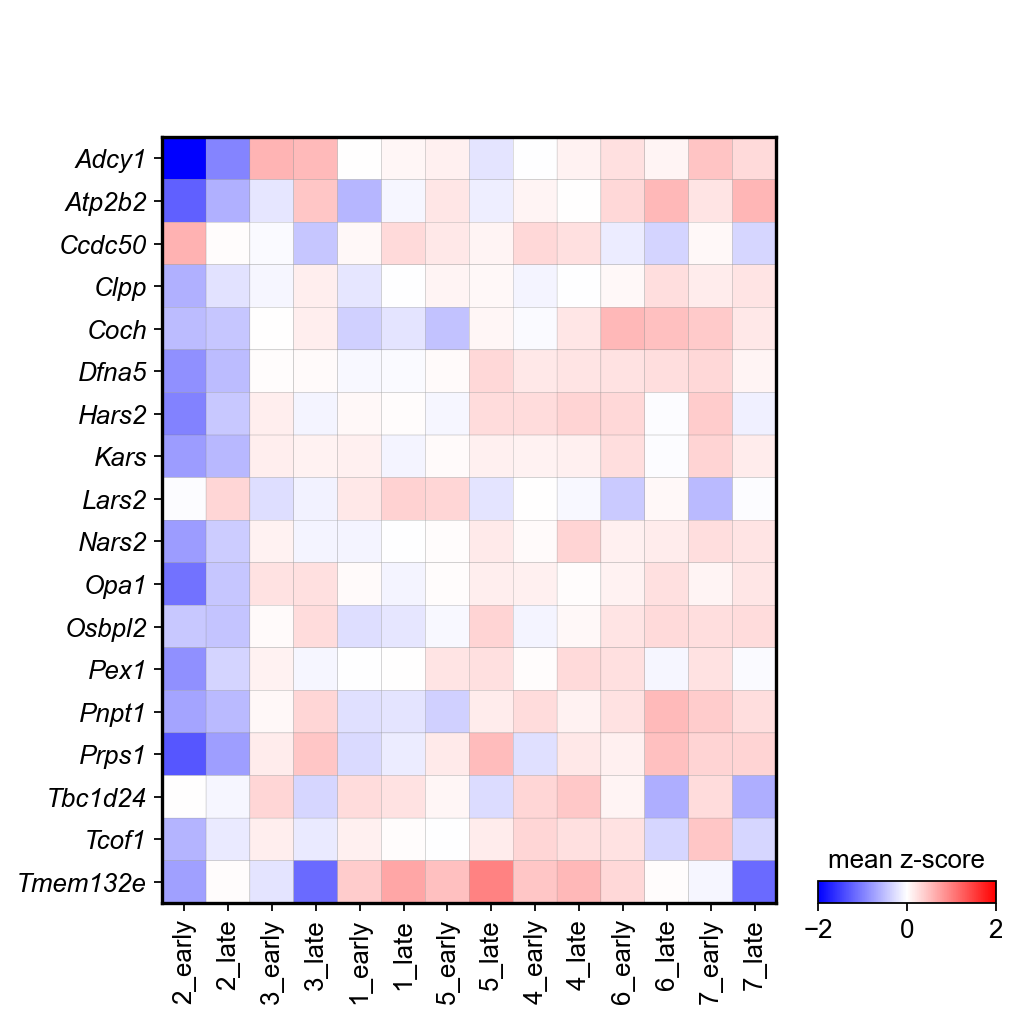

In [40]:
adata.obs.annot=adata.obs.annot.cat.reorder_categories(neworder+['IHC', 'OHC'])
ax=sc.pl.matrixplot(adata_SGN,sgn, 'annot', dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', cmap='bwr',vmin=-2, vmax=2,swap_axes=True,
                 show=False)
plt.setp(ax['mainplot_ax'].get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor",style="italic");
plt.savefig("figures/deafness_SGN.pdf")

In [7]:
non_HC=df_genes[adata[adata.obs.leiden=="18",df_genes].layers["scaled"].mean(axis=0)<1.5]
HC=df_genes[adata[adata.obs.leiden=="18",df_genes].layers["scaled"].mean(axis=0)>1.5]
non_Otic=df_genes[adata[adata.obs.leiden=="19",df_genes].layers["scaled"].mean(axis=0)<1.5]
Otic=df_genes[adata[adata.obs.leiden=="19",df_genes].layers["scaled"].mean(axis=0)>1.5]

In [8]:
Others=np.array(list(set(non_HC).intersection(set(non_Otic))))

In [9]:
Others.sort()

In [10]:
HC=np.array(HC)

In [11]:
Otic=np.array(Otic)

In [12]:
HC.sort()
Otic.sort()

In [13]:
dct={"Otic":Otic.tolist(),"HC":HC.tolist(),"Others":Others.tolist()}

In [17]:
df_genes_SGN=np.array(df.loc[~df.index.isin(["18","19"]),:].columns[df.apply(lambda x: any(x>1))])

In [18]:
df_genes_SGN.sort()

In [19]:
adata_SGN=adata[~adata.obs.leiden.isin(["18","19"])]

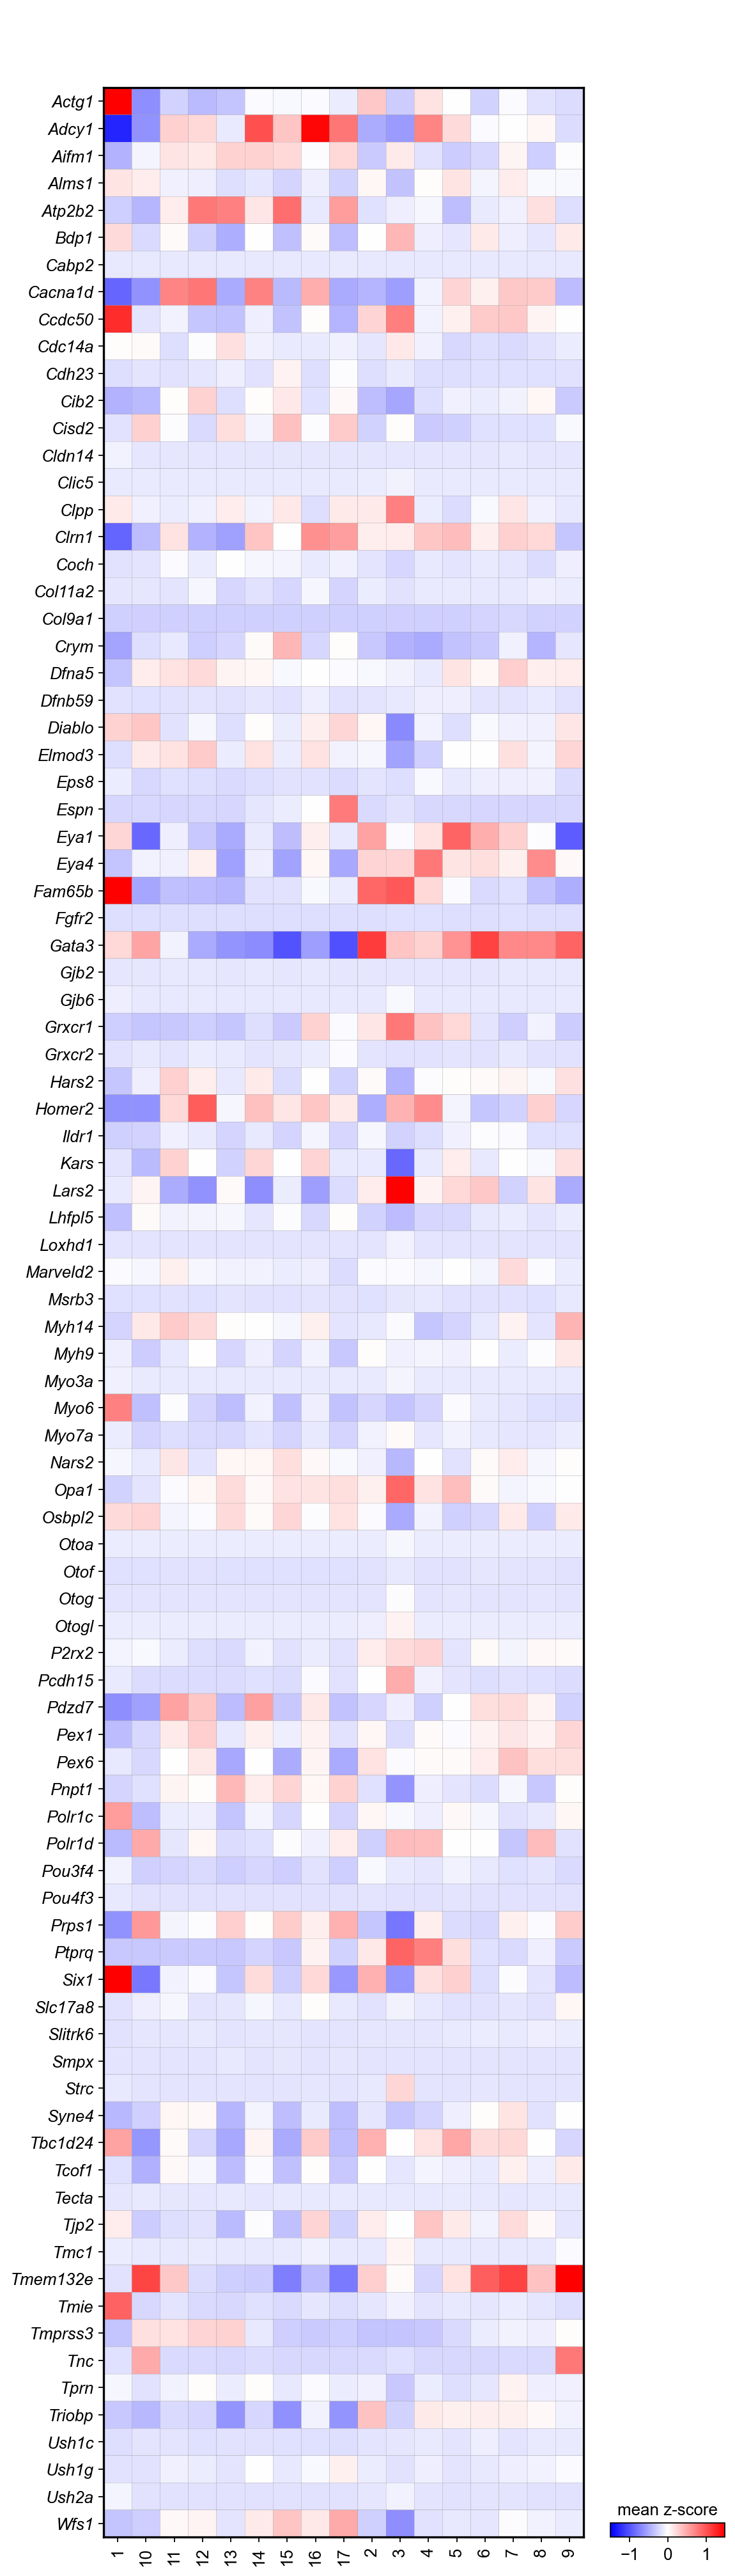

In [20]:
ax=sc.pl.matrixplot(adata_SGN,df_genes_SGN, 'leiden', dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', cmap='bwr',vmin=-1.5, vmax=1.5,swap_axes=True,
                show=False)

plt.setp(ax['mainplot_ax'].get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor",style="italic");
plt.savefig("figures/deafness_SGN.pdf")

In [21]:
df_genes_SGN

array(['Actg1', 'Adcy1', 'Aifm1', 'Alms1', 'Atp2b2', 'Bdp1', 'Cabp2',
       'Cacna1d', 'Ccdc50', 'Cdc14a', 'Cdh23', 'Cib2', 'Cisd2', 'Cldn14',
       'Clic5', 'Clpp', 'Clrn1', 'Coch', 'Col11a2', 'Col9a1', 'Crym',
       'Dfna5', 'Dfnb59', 'Diablo', 'Elmod3', 'Eps8', 'Espn', 'Eya1',
       'Eya4', 'Fam65b', 'Fgfr2', 'Gata3', 'Gjb2', 'Gjb6', 'Grxcr1',
       'Grxcr2', 'Hars2', 'Homer2', 'Ildr1', 'Kars', 'Lars2', 'Lhfpl5',
       'Loxhd1', 'Marveld2', 'Msrb3', 'Myh14', 'Myh9', 'Myo3a', 'Myo6',
       'Myo7a', 'Nars2', 'Opa1', 'Osbpl2', 'Otoa', 'Otof', 'Otog',
       'Otogl', 'P2rx2', 'Pcdh15', 'Pdzd7', 'Pex1', 'Pex6', 'Pnpt1',
       'Polr1c', 'Polr1d', 'Pou3f4', 'Pou4f3', 'Prps1', 'Ptprq', 'Six1',
       'Slc17a8', 'Slitrk6', 'Smpx', 'Strc', 'Syne4', 'Tbc1d24', 'Tcof1',
       'Tecta', 'Tjp2', 'Tmc1', 'Tmem132e', 'Tmie', 'Tmprss3', 'Tnc',
       'Tprn', 'Triobp', 'Ush1c', 'Ush1g', 'Ush2a', 'Wfs1'], dtype=object)

In [38]:
df=pd.DataFrame(0,index=adata_SGN.obs.leiden.cat.categories,
            columns=df_genes_SGN,dtype=float)

In [39]:
for c in adata_SGN.obs.leiden.cat.categories:
    for g in df_genes_SGN:
        df.loc[c,g]=np.array(adata_SGN[adata_SGN.obs.leiden==c,g].layers["scaled"]).mean()

In [40]:
df.to_csv("supp_Fig5b.csv")

In [42]:
adata=sc.read("data/adata_HC.h5ad")

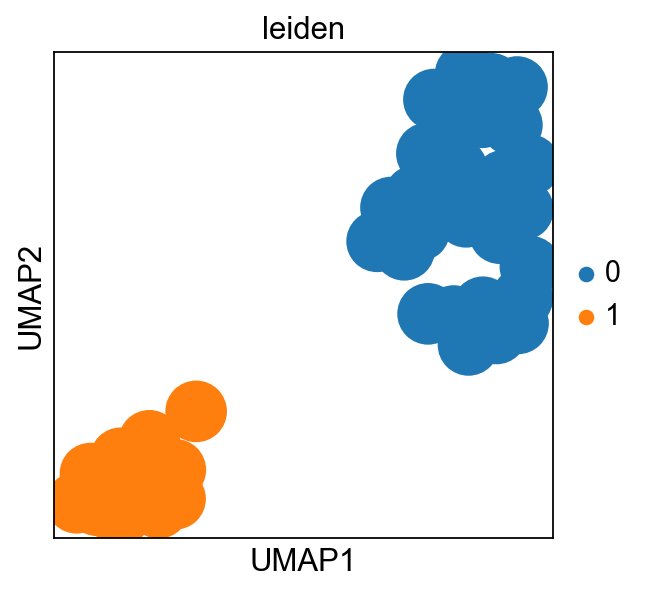

In [47]:
sc.pl.umap(adata, color='leiden')

In [49]:
DVD=pd.read_table("DVD.r8.2.1.2019-12-05.download.tsv")
df_genes=DVD.loc[DVD.FINAL_PATHOGENICITY.isin(['Pathogenic','Likely%20pathogenic']),"GENE"].unique()
DVD_sub=DVD.loc[DVD.FINAL_PATHOGENICITY.isin(['Pathogenic','Likely%20pathogenic']),:]
df_genes=np.char.capitalize(np.array(list(map(lambda x: x.split("%20")[0],df_genes))))

In [50]:
df_genes=adata.var_names[adata.var_names.isin(df_genes)]
df=pd.DataFrame(np.vstack(list(map(lambda c: adata[adata.obs.leiden==c,df_genes].X.A.mean(axis=0),adata.obs.leiden.cat.categories))),
             index=adata.obs.leiden.cat.categories,columns=df_genes)

In [51]:
df_genes_HC=np.array(df.columns[df.apply(lambda x: any(x>1))])

In [52]:
df_genes_HC.sort()

In [53]:
adata.layers["scaled"]=sc.pp.scale(adata.X,copy=True)

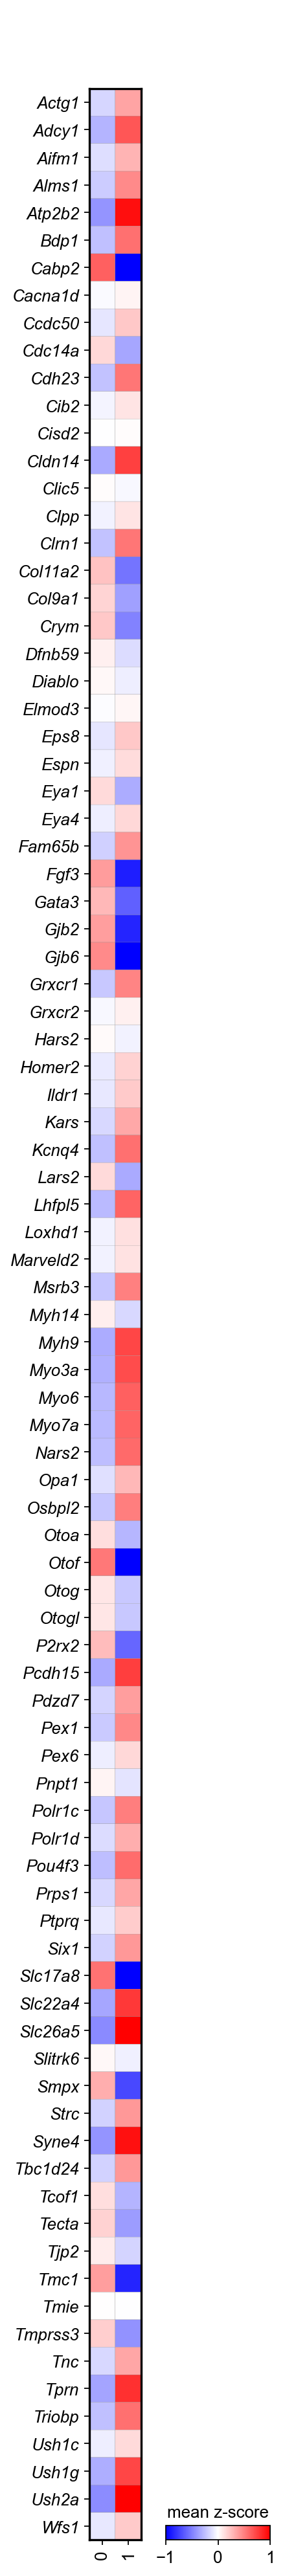

In [54]:
ax=sc.pl.matrixplot(adata,df_genes_HC, 'leiden', dendrogram=False,
                 colorbar_title='mean z-score', layer='scaled', cmap='bwr',vmin=-1, vmax=1,swap_axes=True,
                 show=False)
plt.setp(ax['mainplot_ax'].get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor",style="italic");
plt.savefig("figures/deafness_HC.pdf")

In [58]:
df=pd.DataFrame(0,index=adata.obs.leiden.cat.categories,
            columns=df_genes_HC,dtype=float)

In [59]:
for c in adata.obs.leiden.cat.categories:
    for g in df_genes_HC:
        df.loc[c,g]=np.array(adata[adata.obs.leiden==c,g].layers["scaled"]).mean()

In [60]:
df

,Actg1,Adcy1,Aifm1,Alms1,Atp2b2,Bdp1,Cabp2,Cacna1d,Ccdc50,Cdc14a,...,Tmc1,Tmie,Tmprss3,Tnc,Tprn,Triobp,Ush1c,Ush1g,Ush2a,Wfs1
0,-0.157664,-0.293353,-0.131515,-0.202156,-0.417656,-0.247761,0.619623,-0.019667,-0.096855,0.154665,...,0.380369,0.000767,0.189576,-0.155206,-0.358582,-0.248907,-0.064051,-0.319671,-0.450592,-0.092374
1,0.354745,0.660043,0.295910,0.454851,0.939725,0.557462,-1.394152,0.044251,0.217924,-0.347996,...,-0.855831,-0.001725,-0.426546,0.349212,0.806810,0.560040,0.144116,0.719260,1.013833,0.207842


In [54]:
df.to_csv("supp_Fig5c.csv")